In [3]:
# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.backends.backend_pdf import PdfPages

In [4]:
# Configuração inicial
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

# Carregar os datasets
fornecedores = pd.read_csv('Fornecedores_dataset.csv')
ordens_servico = pd.read_csv('ordens_servico_dataset.csv')
pecas = pd.read_csv('pecas_reposicao_dataset.csv')

# Converter datas
ordens_servico['Data'] = pd.to_datetime(ordens_servico['Data'], dayfirst=True)

# Preparar coluna de peças fornecidas
fornecedores['Peças_Fornecidas'] = fornecedores['Peças_Fornecidas'].str.split(', ')

## Análise Exploratória Básica




=== ANÁLISE EXPLORATÓRIA ===

Estatísticas das Ordens de Serviço:
       Tempo_Reparo_Horas  Custo_Total
count           40.000000    40.000000
mean             2.242500   159.815000
std              0.949463   117.083926
min              1.000000    58.290000
25%              1.575000   105.377500
50%              2.100000   130.795000
75%              2.600000   159.462500
max              5.700000   604.250000

Estatísticas do Estoque de Peças:
count    33.000000
mean      4.757576
std       5.953100
min       0.000000
25%       0.000000
50%       2.000000
75%       7.000000
max      20.000000
Name: Quantidade_Estoque, dtype: float64


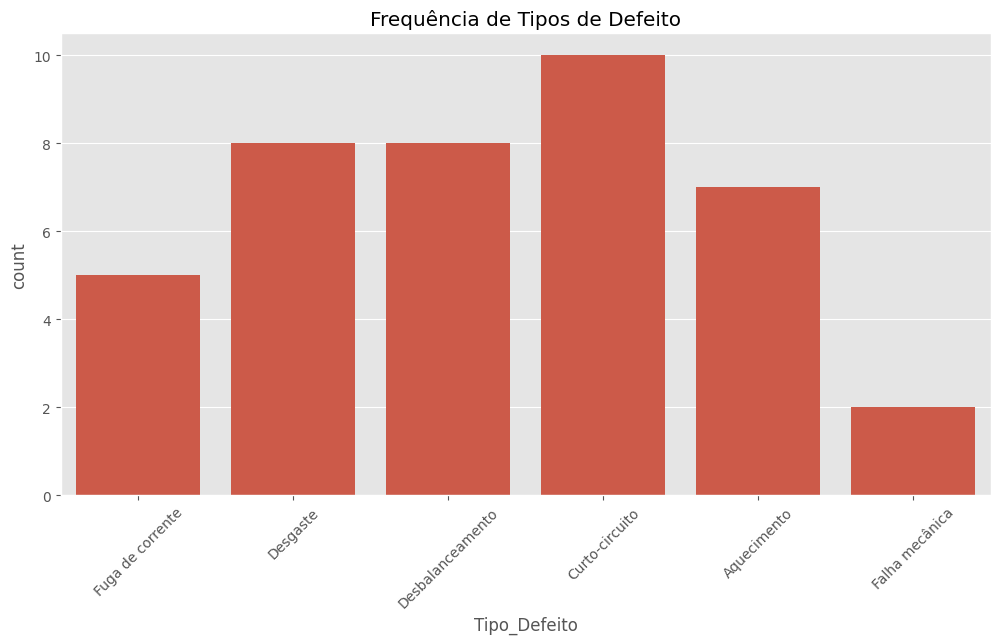

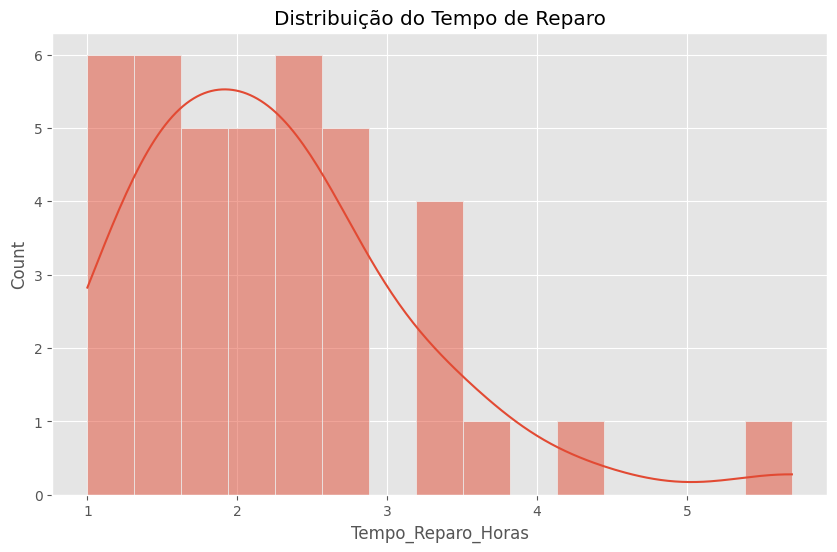

In [5]:
def analise_exploratoria():
    print("\n=== ANÁLISE EXPLORATÓRIA ===")
    
    # Estatísticas básicas
    print("\nEstatísticas das Ordens de Serviço:")
    print(ordens_servico[['Tempo_Reparo_Horas', 'Custo_Total']].describe())
    
    print("\nEstatísticas do Estoque de Peças:")
    print(pecas['Quantidade_Estoque'].describe())
    
    # Visualizações
    plt.figure(figsize=(12, 6))
    sns.countplot(data=ordens_servico, x='Tipo_Defeito')
    plt.title('Frequência de Tipos de Defeito')
    plt.xticks(rotation=45)
    plt.show()
    
    plt.figure(figsize=(10, 6))
    sns.histplot(ordens_servico['Tempo_Reparo_Horas'], bins=15, kde=True)
    plt.title('Distribuição do Tempo de Reparo')
    plt.show()

analise_exploratoria()

## Análise de Fornecedores




=== ANÁLISE DE FORNECEDORES ===

Quantidade de Peças por Fornecedor:
Nome
Casa das Resistências     6
EletroPalma               4
Eletroflash               9
Eletrol                   2
Palma Parafusos           1
R&S Rolamentos           11
Name: Peças_Fornecidas, dtype: int64

Estoque Médio das Peças por Fornecedor:
Nome
Casa das Resistências    15.333333
EletroPalma               8.250000
R&S Rolamentos            2.636364
Eletrol                   1.500000
Eletroflash               0.000000
Palma Parafusos           0.000000
Name: Quantidade_Estoque, dtype: float64


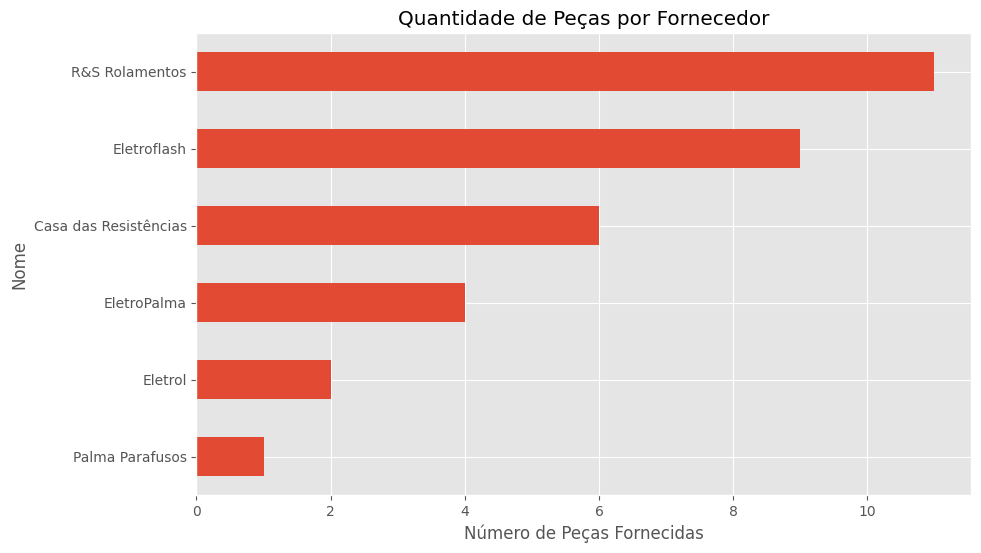

In [6]:
def analise_fornecedores():
    print("\n=== ANÁLISE DE FORNECEDORES ===")
    
    # Expandir lista de peças fornecidas
    fornecedores_exp = fornecedores.explode('Peças_Fornecidas')
    
    # Contar peças por fornecedor
    pecas_por_fornecedor = fornecedores_exp.groupby('Nome')['Peças_Fornecidas'].count()
    print("\nQuantidade de Peças por Fornecedor:")
    print(pecas_por_fornecedor)
    
    # Juntar com dados de peças para análise de estoque
    pecas_fornecedor = pd.merge(fornecedores_exp, pecas, left_on='Peças_Fornecidas', right_on='ID_Peça')
    
    # Estoque médio por fornecedor
    estoque_medio = pecas_fornecedor.groupby('Nome')['Quantidade_Estoque'].mean()
    print("\nEstoque Médio das Peças por Fornecedor:")
    print(estoque_medio.sort_values(ascending=False))
    
    # Visualização
    plt.figure(figsize=(10, 6))
    pecas_por_fornecedor.sort_values().plot(kind='barh')
    plt.title('Quantidade de Peças por Fornecedor')
    plt.xlabel('Número de Peças Fornecidas')
    plt.show()

analise_fornecedores()

## Análise de Peças de Reposição


=== ANÁLISE DE PEÇAS DE REPOSIÇÃO ===

Peças mais utilizadas em ordens de serviço:
Peças_Utilizadas
P001    5
P004    4
P024    4
P022    2
P028    2
P011    2
P007    2
P025    2
P002    2
P006    2
Name: count, dtype: int64

Custo médio por categoria de peça:
                      Custo_Unitário  Custo_Total
Categoria                                        
Contactor Elétrico         71.500000   194.200000
Inversor Elétrico         646.666667   538.526667
Resistência Elétrica       52.333333   137.910000
Retentor                    6.380000   104.935000
Rolamento                  12.440000   118.339333
Solenoide                  45.500000   152.410000

Peças com risco de falta de estoque:
   ID_Peça          Nome_Peça  Quantidade_Estoque  Demanda_Mensal_Estimada
0     P001     Rolamento 6203                   2                        4
2     P003     Rolamento 6305                   4                        5
9     P010      Contactor 18A                   0                        0

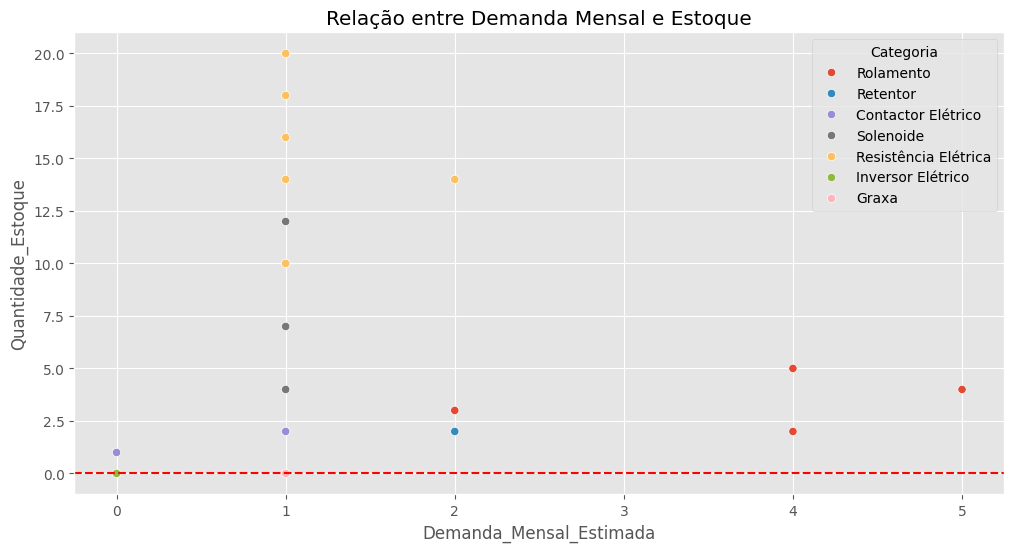

In [7]:
def analise_pecas():
    print("\n=== ANÁLISE DE PEÇAS DE REPOSIÇÃO ===")
    
    # Peças mais utilizadas em ordens de serviço
    pecas_utilizadas = ordens_servico['Peças_Utilizadas'].value_counts().head(10)
    print("\nPeças mais utilizadas em ordens de serviço:")
    print(pecas_utilizadas)
    
    # Juntar dados de peças com ordens de serviço
    pecas_os = pd.merge(ordens_servico, pecas, left_on='Peças_Utilizadas', right_on='ID_Peça')
    
    # Custo médio por categoria de peça
    custo_medio_categoria = pecas_os.groupby('Categoria')[['Custo_Unitário', 'Custo_Total']].mean()
    print("\nCusto médio por categoria de peça:")
    print(custo_medio_categoria)
    
    # Análise de estoque vs demanda
    pecas['Estoque_vs_Demanda'] = pecas['Quantidade_Estoque'] / pecas['Demanda_Mensal_Estimada']
    pecas_risco = pecas[(pecas['Estoque_vs_Demanda'] < 1) | (pecas['Quantidade_Estoque'] == 0)]
    print("\nPeças com risco de falta de estoque:")
    print(pecas_risco[['ID_Peça', 'Nome_Peça', 'Quantidade_Estoque', 'Demanda_Mensal_Estimada']])
    
    # Visualização
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=pecas, x='Demanda_Mensal_Estimada', y='Quantidade_Estoque', hue='Categoria')
    plt.title('Relação entre Demanda Mensal e Estoque')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()

analise_pecas()

## Análise de Ordens de Serviço


=== ANÁLISE DE ORDENS DE SERVIÇO ===

Número de ordens por mês:
Data
2025-02-28     7
2025-03-31    12
2025-04-30    11
2025-05-31    10
Freq: ME, dtype: int64

Máquinas com mais ordens de serviço:
ID_Máquina
M002    9
M007    5
M008    4
M003    4
M009    4
Name: count, dtype: int64

Custo médio por tipo de defeito:
Tipo_Defeito
Falha mecânica      327.220000
Desbalanceamento    186.915000
Desgaste            176.766250
Fuga de corrente    141.938000
Curto-circuito      140.410000
Aquecimento         102.131429
Name: Custo_Total, dtype: float64

Tempo médio de reparo por máquina:
ID_Máquina
M004    4.150000
M005    2.625000
M002    2.522222
M007    2.400000
M009    1.950000
Name: Tempo_Reparo_Horas, dtype: float64


C:\Users\marco\AppData\Local\Temp\ipykernel_9028\2372430760.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ordens_mes = ordens_servico.set_index('Data').resample('M').size()


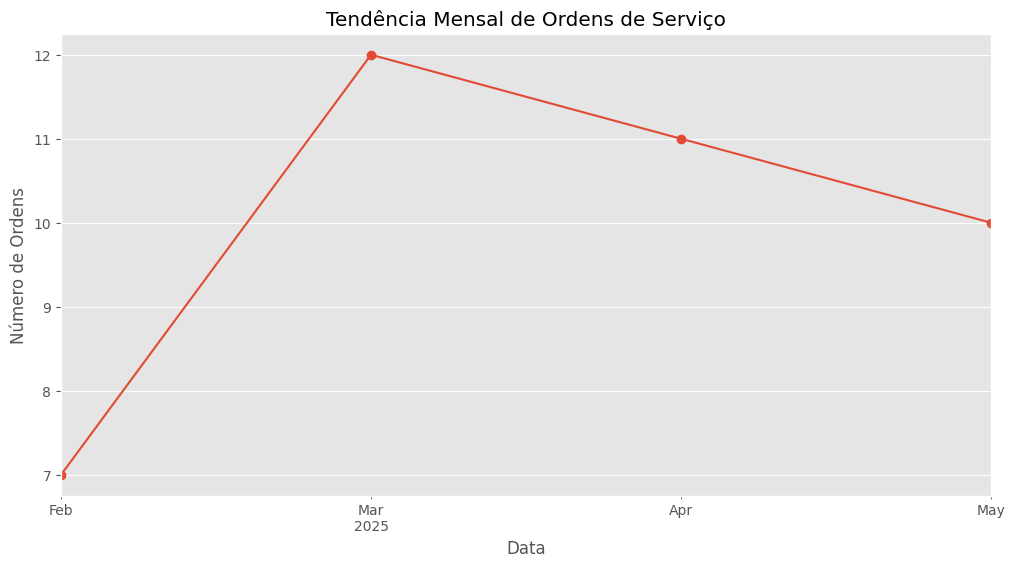

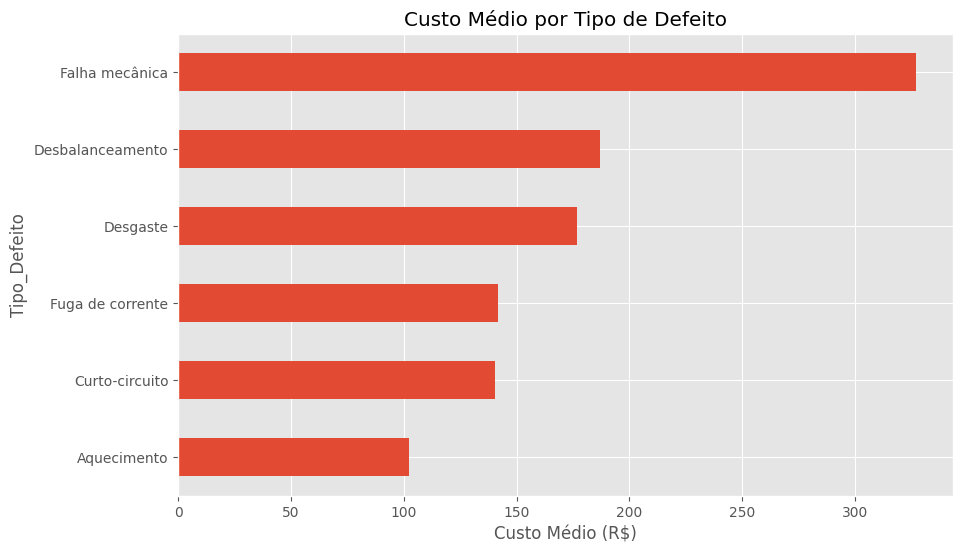

In [8]:
def analise_ordens_servico():
    print("\n=== ANÁLISE DE ORDENS DE SERVIÇO ===")
    
    # Tendência temporal
    ordens_mes = ordens_servico.set_index('Data').resample('M').size()
    print("\nNúmero de ordens por mês:")
    print(ordens_mes)
    
    # Máquinas com mais problemas
    maquinas_problema = ordens_servico['ID_Máquina'].value_counts().head(5)
    print("\nMáquinas com mais ordens de serviço:")
    print(maquinas_problema)
    
    # Custo médio por tipo de defeito
    custo_defeito = ordens_servico.groupby('Tipo_Defeito')['Custo_Total'].mean().sort_values(ascending=False)
    print("\nCusto médio por tipo de defeito:")
    print(custo_defeito)
    
    # Tempo médio de reparo por máquina
    tempo_maquina = ordens_servico.groupby('ID_Máquina')['Tempo_Reparo_Horas'].mean().sort_values(ascending=False)
    print("\nTempo médio de reparo por máquina:")
    print(tempo_maquina.head())
    
    # Visualizações
    plt.figure(figsize=(12, 6))
    ordens_mes.plot(marker='o')
    plt.title('Tendência Mensal de Ordens de Serviço')
    plt.ylabel('Número de Ordens')
    plt.show()
    
    plt.figure(figsize=(10, 6))
    custo_defeito.sort_values().plot(kind='barh')
    plt.title('Custo Médio por Tipo de Defeito')
    plt.xlabel('Custo Médio (R$)')
    plt.show()

analise_ordens_servico()

## Correlações e Regressão Linear


=== ANÁLISE DE CORRELAÇÃO E REGRESSÃO ===

Matriz de correlação:
                    Tempo_Reparo_Horas  Custo_Total  Custo_Unitário  \
Tempo_Reparo_Horas            1.000000     0.693971        0.753135   
Custo_Total                   0.693971     1.000000        0.859889   
Custo_Unitário                0.753135     0.859889        1.000000   
Quantidade_Estoque            0.156323    -0.254444       -0.208225   

                    Quantidade_Estoque  
Tempo_Reparo_Horas            0.156323  
Custo_Total                  -0.254444  
Custo_Unitário               -0.208225  
Quantidade_Estoque            1.000000  


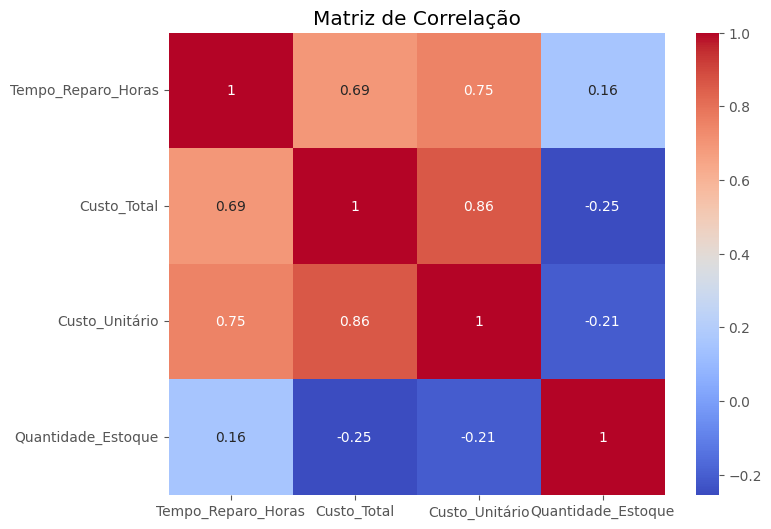


Resultados da Regressão Linear:
Coeficientes: [30.08139703  0.43330803]
Intercepto: 63.64023304033839
R²: -0.43
RMSE: 45.64


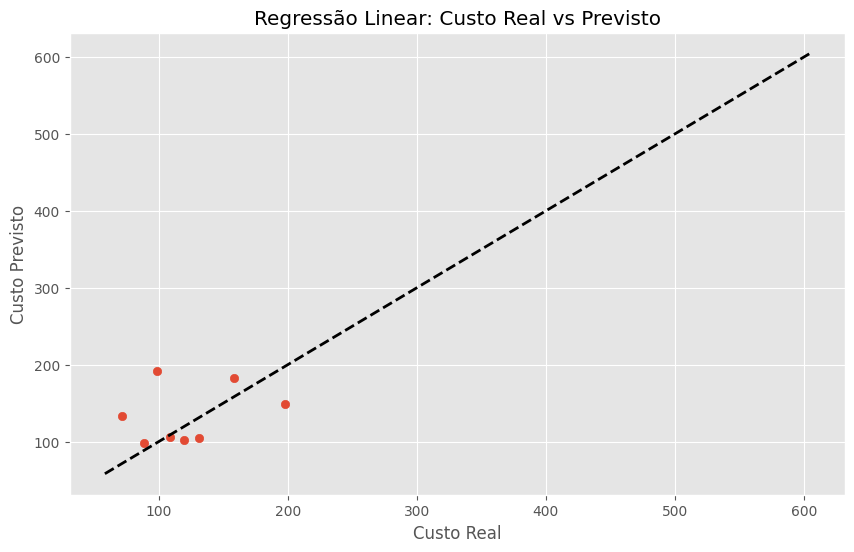

In [9]:
def analise_correlacao_regressao():
    print("\n=== ANÁLISE DE CORRELAÇÃO E REGRESSÃO ===")
    
    # Juntar dados para análise
    dados_completos = pd.merge(ordens_servico, pecas, left_on='Peças_Utilizadas', right_on='ID_Peça')
    
    # Matriz de correlação
    corr = dados_completos[['Tempo_Reparo_Horas', 'Custo_Total', 'Custo_Unitário', 'Quantidade_Estoque']].corr()
    print("\nMatriz de correlação:")
    print(corr)
    
    # Visualização da correlação
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title('Matriz de Correlação')
    plt.show()
    
    # Regressão Linear: Prever custo total baseado em outras variáveis
    X = dados_completos[['Tempo_Reparo_Horas', 'Custo_Unitário']]
    y = dados_completos['Custo_Total']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    print("\nResultados da Regressão Linear:")
    print(f"Coeficientes: {model.coef_}")
    print(f"Intercepto: {model.intercept_}")
    print(f"R²: {r2_score(y_test, y_pred):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
    
    # Visualização dos resultados
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.xlabel('Custo Real')
    plt.ylabel('Custo Previsto')
    plt.title('Regressão Linear: Custo Real vs Previsto')
    plt.show()

analise_correlacao_regressao()

## Recomendações para Gestores

In [ ]:

def gerar_recomendacoes_graficos_pdf():
    print("\n=== RECOMENDAÇÕES PARA GESTORES ===")
    
    # Criar um arquivo PDF para salvar todos os gráficos
    with PdfPages('Recomendacoes_Gestores.pdf') as pdf:
        
        # 1. Análise de estoque crítico
        plt.figure(figsize=(12, 6))
        pecas_sem_estoque = pecas[pecas['Quantidade_Estoque'] == 0]
        pecas_sem_estoque = pecas_sem_estoque.sort_values('Demanda_Mensal_Estimada', ascending=False)
        
        if not pecas_sem_estoque.empty:
            sns.barplot(data=pecas_sem_estoque, x='Nome_Peça', y='Demanda_Mensal_Estimada', hue='Categoria', dodge=False)
            plt.title('1. Peças sem estoque com maior demanda mensal (prioridade de reposição)')
            plt.ylabel('Demanda Mensal Estimada')
            plt.xlabel('Nome da Peça')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            pdf.savefig()
            plt.show()
        else:
            print("\nNão há peças sem estoque no momento.")
        
        # 2. Fornecedores críticos
        plt.figure(figsize=(12, 6))
        pecas_os = pd.merge(ordens_servico, pecas, left_on='Peças_Utilizadas', right_on='ID_Peça')
        fornecedor_impacto = pecas_os.groupby('Fornecedor')['Custo_Total'].sum().sort_values(ascending=False).head(5)
        
        fornecedor_impacto.plot(kind='bar', color=sns.color_palette("husl", 5))
        plt.title('2. Fornecedores com maior impacto financeiro (priorizar relações)')
        plt.ylabel('Custo Total (R$)')
        plt.xlabel('Fornecedor')
        plt.tight_layout()
        pdf.savefig()
        plt.show()
        
        # 3. Máquinas problemáticas
        plt.figure(figsize=(12, 6))
        maquinas_custo = ordens_servico.groupby('ID_Máquina')['Custo_Total'].sum().sort_values(ascending=False).head(5)
        maquinas_tempo = ordens_servico.groupby('ID_Máquina')['Tempo_Reparo_Horas'].sum().sort_values(ascending=False).head(5)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        maquinas_custo.plot(kind='bar', ax=ax1, color='skyblue')
        ax1.set_title('Custo Total por Máquina')
        ax1.set_ylabel('Custo Total (R$)')
        
        maquinas_tempo.plot(kind='bar', ax=ax2, color='salmon')
        ax2.set_title('Tempo Total de Reparo por Máquina')
        ax2.set_ylabel('Horas de Reparo')
        
        plt.suptitle('3. Máquinas com maior custo e tempo de manutenção')
        plt.tight_layout()
        pdf.savefig()
        plt.show()
        
        # 4. Peças mais utilizadas
        plt.figure(figsize=(12, 6))
        pecas_frequentes = ordens_servico['Peças_Utilizadas'].value_counts().head(5)
        pecas_frequentes_df = pd.DataFrame(pecas_frequentes).reset_index()
        pecas_frequentes_df.columns = ['ID_Peça', 'Frequência']
        pecas_frequentes_df = pd.merge(pecas_frequentes_df, pecas, on='ID_Peça')
        
        sns.barplot(data=pecas_frequentes_df, x='Nome_Peça', y='Frequência', hue='Categoria', dodge=False)
        plt.title('4. Peças mais utilizadas em reparos (considerar estoque de segurança)')
        plt.ylabel('Número de Utilizações')
        plt.xlabel('Nome da Peça')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        pdf.savefig()
        plt.show()
        
        # 5. Tipos de defeito mais caros
        plt.figure(figsize=(12, 6))
        defeitos_caros = ordens_servico.groupby('Tipo_Defeito')['Custo_Total'].mean().sort_values(ascending=False).head(5)
        
        defeitos_caros.plot(kind='bar', color=sns.color_palette("flare"))
        plt.title('5. Tipos de defeito com maior custo médio (focar em prevenção)')
        plt.ylabel('Custo Médio (R$)')
        plt.xlabel('Tipo de Defeito')
        plt.tight_layout()
        pdf.savefig()
        plt.show()
        
        # 6. Relação estoque vs demanda
        plt.figure(figsize=(12, 8))
        pecas['Estoque_vs_Demanda'] = pecas['Quantidade_Estoque'] / pecas['Demanda_Mensal_Estimada']
        pecas['Risco'] = np.where(pecas['Estoque_vs_Demanda'] < 1, 'Risco', 'OK')
        
        sns.scatterplot(data=pecas, x='Demanda_Mensal_Estimada', y='Quantidade_Estoque', 
                        hue='Risco', style='Categoria', s=100)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('6. Relação entre Demanda Mensal e Estoque (Identificação de Risco)')
        plt.xlabel('Demanda Mensal Estimada')
        plt.ylabel('Quantidade em Estoque')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        pdf.savefig()
        plt.show()
        
        print("\nRelatório de recomendações salvo como 'Recomendacoes_Gestores.pdf'")

gerar_recomendacoes_graficos_pdf()